# Using Generative Adversarial Networks (GAN) to generate new Pokemon characters

## PokeGAN

In 1995 there were 151 different Pokemon. In 2017 there are 802, and this number will continue to grow with each new game release. 

I started to wonder how long it will be until the creators are going to run out of ideas. I also began to wonder if machine learning, specifically a generative model, could come up with some ideas for new pokemon. 



In [2]:
import tensorflow as tf
import numpy as np
import pandas as pd
import tflearn 
from tflearn.layers.conv import conv_2d, conv_2d_transpose, max_pool_2d
from tflearn.layers.normalization import batch_normalization
from tflearn.layers.core import fully_connected
from tflearn.variables import get_layer_variables_by_name 

## The Model

I use a Convolutional Generative Adversarial Model (CGAN) for this task. I have constructed the model in tensorflow.

The GAN principal pits two neural networks (adversaries) against each other. The goal of one network is to generate forged data that decives the other network into thinking they are real (came from the dataset). The goal of his adversary is to be able to distinguish the fake from the real data, catching the fraudulent sample.

In [9]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [48]:
tf.reset_default_graph()

In [49]:
def sample_z(zdim):
        """
        Sample from the noise prio
        """
        return np.random.uniform(-1.,1,size = [zdim])

# outside functions for model generation
def generator(z,dc1filts,dc1filtsize,dc2filts,dc2filtsize,imsize):
    """
    Constructs the generative convolutional network.
    """
    # fully connected to the noise vector
    x = fully_connected(z,4*4*1024,activation = 'linear')
    x = tf.reshape(x,shape=[-1,4,4,1024]) 
    
    nfilts = [512,256,128,3] # number of filters
    filtsize = [2,2,2,2]
    
    for i in range(1,len(nfilts)):
        if i < len(nfilts)-1:
            x = tf.nn.relu(batch_normalization(conv_2d_transpose(x,dc2filts,dc2filtsize,\
                            output_shape=(imsize,imsize),name = 'dconv%s' % i,scope = 'dconv%s' % i)))
            print('dconv', str(i+1),x.get_shape())
        else:
            x = tf.tanh(batch_normalization(conv_2d_transpose(x,dc2filts,dc2filtsize,\
                            output_shape=(imsize,imsize),name = 'dconv%s' % i,scope = 'dconv%s' % i)))
            print('dconv', str(i+1),x.get_shape())
            
    return x
    
    
def discriminator(img,c1filts,c1filtsize,c2filts,c2filtsize,first=True):
    """
    Constructs the discriminative convolutional network.
    """
    #share weights for second time called. not for first.
    if first == True:
        with tf.variable_scope("conv1"):
            # convolutional layer 1 with batch normalization before using relu activation
            conv1 = (tf.nn.relu(batch_normalization(tf.layers.conv2d(img,c1filts, \
                        c1filtsize, strides = 2 , name='conv1', reuse=False),scope='bnorm1')))#,2,1,'SAME')
        
        with tf.variable_scope("conv2"):
            # convolutional layer 2
            conv2 = (tf.nn.relu(batch_normalization(tf.layers.conv2d(conv1,c2filts, \
                        c2filtsize, strides = 2 , name='conv2', reuse=False),scope='bnorm2')))#,2,1,'SAME')   
        
        # fully connected layer which calculates probability of image being real 
        fc1 = fully_connected(tf.contrib.layers.flatten(conv2),1, activation = 'sigmoid', name= 'dense_out',\
                            reuse=False, scope='dense_out')
    else:
        #reuse the weights
        with tf.variable_scope("conv1"):
            # convolutional layer 1 with batch normalization before using relu activation
            conv1 = (tf.nn.relu(batch_normalization(tf.layers.conv2d(img,c1filts, \
                        c1filtsize, strides = 2 , name='conv1', reuse=True),scope='bnorm1', reuse=True)))#,2,1,'SAME')
        
        with tf.variable_scope("conv2"):
            # convolutional layer 2
            conv2 = (tf.nn.relu(batch_normalization(tf.layers.conv2d(conv1,c2filts, \
                        c2filtsize, strides = 2 , name='conv2', reuse=True),scope='bnorm2', reuse=True)))#,2,1,'SAME')   
        
        # fully connected layer which calculates probability of image being real 
        fc1 = fully_connected(conv2,1, activation = 'sigmoid', name= 'dense_out',\
                             scope = 'dense_out',reuse=True)
    return fc1
    
# construct our model class
class GAN:
    def __init__(self,nchan=4,c1filts=5,c1filtsize=10,c2filts=5,c2filtsize=5,\
                dc1filts=5,dc1filtsize=5,dc2filts=4,dc2filtsize=10,zdim1=16,zdim2=16,imsize=64):
        """
        Generative adversarial convolutional model which we can 
        train, adjust & add hyperparameters to.
        Starting with a 2 layer convolutional/deconvolutional network
        for both the generator & discriminator.
        """
        # status of model is not compiled yet
        self.initialized = False
        
        ### set some default parameters up
        # conv layers
        self.c1filts,self.c1filtsize,self.c2filts,self.c2filtsize = (c1filts,c1filtsize,c2filts,c2filtsize)
        
        # deconv layers
        self.dc1filts,self.dc1filtsize,self.dc2filts,self.dc2filtsize = (dc1filts,dc1filtsize,dc2filts,dc2filtsize)
        
        # z variable & dimensions
        self.zdim1,self.zdim2,self.nchan,self.imsize = (zdim1,zdim2,nchan,imsize)
        
        
    def build(self):
        """
        Calls the generator & discriminator networks, initializes the
        tf session / variables and builds loss function & optimizer.
        """
        ### define the inputs
        # underlying "z" variable - it is same tensor rank as our images
        self.z = tf.placeholder(tf.float32, shape = [None,self.zdim1])
        
        # image input as 4d tensor
        self.img = tf.placeholder(tf.float32,shape = [None,self.imsize,self.imsize,self.nchan])
        
        ### forward propagate through network
        # sample from "z" and pass through generator
        self.g = generator(self.z,self.dc1filts,self.dc1filtsize,self.dc2filts,self.dc2filtsize,self.imsize) 
        print('shape of "Z"', self.z.get_shape())
        print('shape of G(z)',self.g.get_shape())
        print('shape of img', self.img.get_shape)
        
        # output for real & fake images from the batch
        self.d_real = discriminator(self.img,self.c1filts,self.c1filtsize,self.c2filts,self.c2filtsize,first=True)
        # run again, so share weights
        self.d_fake = discriminator(self.g,self.c1filts,self.c1filtsize,self.c2filts,self.c2filtsize,first=False)
        
        ### get loss functions 
        # negative because we want to maximize these log probabilities
        self.g_loss = -tf.reduce_mean(tf.log(self.d_fake))
        self.d_loss = -tf.reduce_mean(tf.log(self.d_real) + tf.log(1. - self.d_fake))
        
        ### define training rules - using adam optimizer
        # need to only optimize over one model's variables at a time
        # use get_layer_variables_by_name from tflearn
        # to get back the names of the parameters
        
        self.g_var = [] # empty lists of parameters - for use later
        self.d_var = []
        
        gvars = ['dconv1','dconv2'] # list of relevant layer names to get their weights back
        dvars = ['conv1','conv2','dense_out']
        for i in range(len(gvars)):
            self.g_var.append(get_layer_variables_by_name(gvars[i]))
        for i in range(len(dvars)):
            self.d_var.append( get_layer_variables_by_name(dvars[i]))
        
        # need to flatten the resultant list of lists
        self.g_var = [val for sublist in self.g_var for val in sublist]
        self.d_var = [val for sublist in self.d_var for val in sublist]
        print('gvars is', self.g_var)
        print('dvars is', self.d_var)
        
        # define the train steps
        self.g_train_op = tf.train.AdamOptimizer().minimize(self.g_loss, var_list=self.g_var)
        self.d_train_op = tf.train.AdamOptimizer().minimize(self.d_loss, var_list=self.d_var)
        
        # start the tf session
        self.sess = tf.Session()
        self.sess.run(tf.global_variables_initializer())
        
        # model is initialized
        print('model has been successfully built')
        self.initialized = True
             
    def close(self):
        # end the tensorflow session
        self.sess.close()
        print('Terminated the tensorflow session')
        
    def train(self,x, y, b_size, iters = 100):
        """
        Runs some training iterations on the model
        given a batch of data (x, y), the number of iterations 
        and batch size
        """
        # check that the model is properly built first
        if self.initialized != True:
            print('model has not been compiled yet!')
            raise 
        
        # now we can do the training
        for i in range(iters):
            # get batch of data
            X_mb, _ = mnist.train.next_batch(mb_size)

            _, d_loss_curr = self.sess.run([self.d_train_op, self.d_loss], feed_dict={img: x, z: sample_Z(b_size)})
            _, g_loss_curr = self.sess.run([self.g_train_op, self.g_loss], feed_dict={z: sample_Z(b_size)})
              
    def generate_lattice(self):
        """
        Generates a lattice of new pokemon images from the generator network.
        """
        pass  # work on later

## The Data
I have acquired an image of a moderate amount of different pokemon, which look evenly spaced and I should be able create these into individual images that can be used as a dataset. 

The data has channels. Each sub image is a square of 64 pixels


In [368]:
%matplotlib inline

from PIL import Image
from matplotlib.pyplot import imshow
import matplotlib.pyplot as plt

# read in pokemon dataset
img = Image.open('all_pokemon.jpg')

# looking at the shape of this image - 1024 by 1600 pixels and 3 channels
print(np.shape(np.array(img)))

(1024, 1600, 3)


In [5]:
# split the image into multiple images
pkmn = []  # this will be the main dataset
# loop over rows
for i in range(16):
    # loop over columns:
    for j in range(25):
        # avoid whitespaces...
        tmp_img =  img.crop((64*j, 64*i,64*(j + 1), 64*(i+1)))
        if np.max(np.array(tmp_img)) > 0: # discard the image if it doesn't have any content.
            pkmn.append(tmp_img )
            
# save them as files           
for i in range(len(pkmn)):
    pkmn[i].save('data/pkmn%s.jpg' % i)

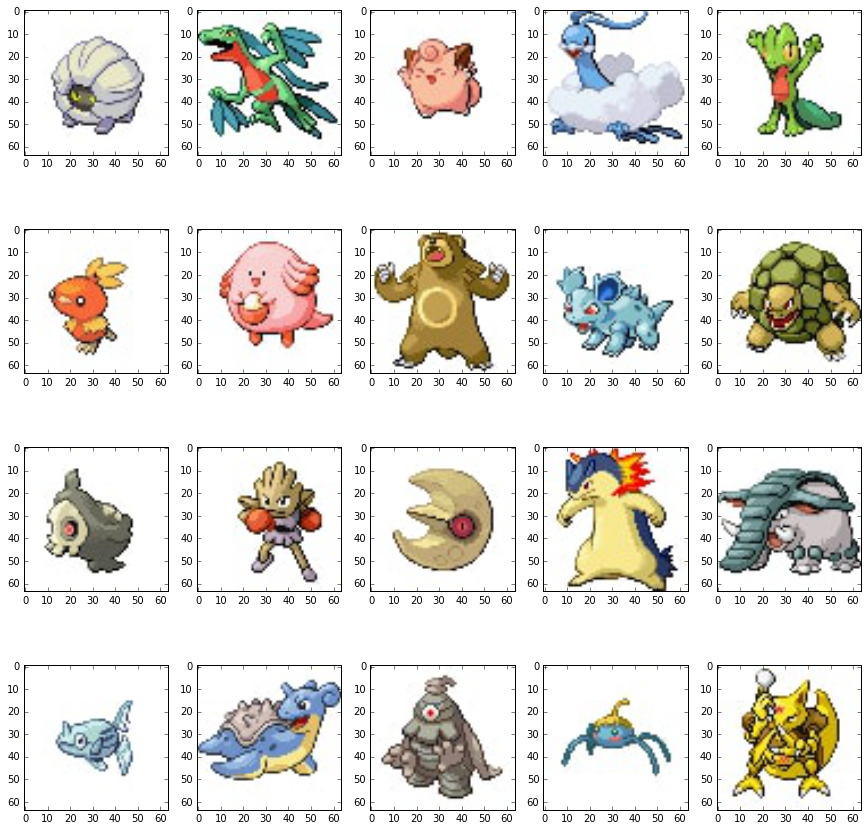

In [366]:
# let's see what some of our data looks like
# reload this cell to see different pictures

import random
rands = random.sample(range(1,len(pkmn)), 20)

fig = plt.figure(figsize=(15, 15))
for i in range(20):
    a=fig.add_subplot(4,5,i+1)
    plt.imshow(pkmn[rands[i]])


In [7]:
### images need to be normalized / scaled to fit into the model
# so I made a normalizer object to handle multidimensional np arrays
class normalizer:
    def __init__(self,x,type='tanh'):
        """
        Sets up a normalizer object for our multidimensional arrays & fits it to data
        """
        self.img = x
        self.mx = np.max(self.img)
        self.mn = np.min(self.img)
        
        # normalize & unnormalize given these parameters
        self.normalized = 2*(self.img-self.mn)/(self.mx-self.mn)-1
        self.unnormalized = ((self.img+1)/2)*(self.mx-self.mn) + self.mn
    
    def load_new_image(self,im):
        # for new images we can load in then normalize based on the parameters
        self.img = im # replace old image with this, keep same parameters
        self.normalized = 2*(self.img-self.mn)/(self.mx-self.mn)-1
        self.unnormalized = ((self.img+1)/2)*(self.mx-self.mn) + self.mn  
        
    def refit(self):
        self.mx = np.max(self.img)
        self.mn =np.min(self.img)
        self.normalized = 2*(self.img-self.mn)/(self.mx-self.mn)-1
        self.unnormalized = ((self.img+1)/2)*(self.mx-self.mn) + self.mn

In [8]:
# turn data into a numpy array & normalize - for use in tensorflow

pkmn_data = np.array([np.array(p) for p in pkmn])
n = normalizer(pkmn_data)
X = n.normalized

print(np.shape(X)) # 4d tensor

# note that there are only 400 samples, which is a bit low - although it is a start

(400, 64, 64, 3)


# Visualizing the Dataset
We can see how similar pokemon are by a graph! I will use autoencodings as coordinates for their sprites.

I make this simpler by using only one channel as inputs to the autoencoder, which has a relu nonlinearity.

In [35]:
### reshape the inputs
def shaper(img):
    # image input as shape
    # [height,width,channels]
    # take channel '0' only
    img = img[:,:,0]
    # flatten all pixels:   
    return img.flatten()
    
### create dataset - use normalized array
pkmn_1d = np.array([ shaper(pkmn_data[i]) for i in range(len(pkmn_data)) ],dtype=float )
print(pkmn_1d)


[[ 255.  255.  255. ...,  255.  255.  255.]
 [ 255.  255.  255. ...,  255.  255.  255.]
 [ 255.  255.  255. ...,  255.  253.  255.]
 ..., 
 [ 255.  255.  255. ...,  255.  255.  255.]
 [ 255.  255.  255. ...,  255.  255.  255.]
 [ 255.  255.  255. ...,  255.  255.  255.]]


In [176]:
# use keras for quick access to tf API
from keras.layers import Input, Dense,Flatten, Conv2D, MaxPooling2D, UpSampling2D, Reshape
from keras.models import Model
from keras import backend as K

# setup placeholders
input_img = Input(shape=(64, 64, 3))  

x = Conv2D(32, 3, 3, activation='relu')(input_img)
x = MaxPooling2D((2, 2))(x)
x = Conv2D(16, 3, 3, activation='relu')(x)
x = MaxPooling2D((2, 2))(x)
x = Flatten()(Conv2D(8, 3, 3, activation='relu')(x))
encoded = Dense(2,activation='relu')(x)

print(encoded.get_shape())
# at this point the representation is (4, 4, 8) i.e. 128-dimensional
# need to rebuild a dense layer then reshape:
x = Dense(128,activation='relu')(encoded)
print(x.get_shape())
x = Reshape([4,4,8])(x)
x = Conv2D(8, 3, 3, activation='relu')(x)
x = UpSampling2D((4,4))(x)
x = Conv2D(16, 3, 3, activation='relu')(x)
x = UpSampling2D((2, 2))(x)
x = Conv2D(32, 2, 2, activation='relu')(x)
x = UpSampling2D((6, 6))(x)
decoded = Conv2D(3, 3, 3, activation='relu')(x)

# compile model
autoencoder = Model(input_img, decoded)
autoencoder.compile(optimizer='rmsprop', loss='mae')

# make encoder model - to retrieve our images
encoder = Model(input_img,encoded)

(?, 2)
(?, 128)


In [353]:
### fit model
autoencoder.fit(pkmn_data/255.,pkmn_data/255.,nb_epoch = 5)

Epoch 1/5
400/400 [==============================] - 3s - loss: 0.1286     
Epoch 2/5
400/400 [==============================] - 3s - loss: 0.1266     
Epoch 3/5
400/400 [==============================] - 3s - loss: 0.1288     
Epoch 4/5
400/400 [==============================] - 3s - loss: 0.1276     
Epoch 5/5
400/400 [==============================] - 2s - loss: 0.1277     


In [354]:
### for each sample obtain coordinates:
coords = encoder.predict(pkmn_data/255.)

# rescale data to plot
def minmax(arr):
    return (arr-np.min(arr))/(np.max(arr)-np.min(arr))
coords[:,0] = minmax(coords[:,0])
coords[:,1] = minmax(coords[:,1])

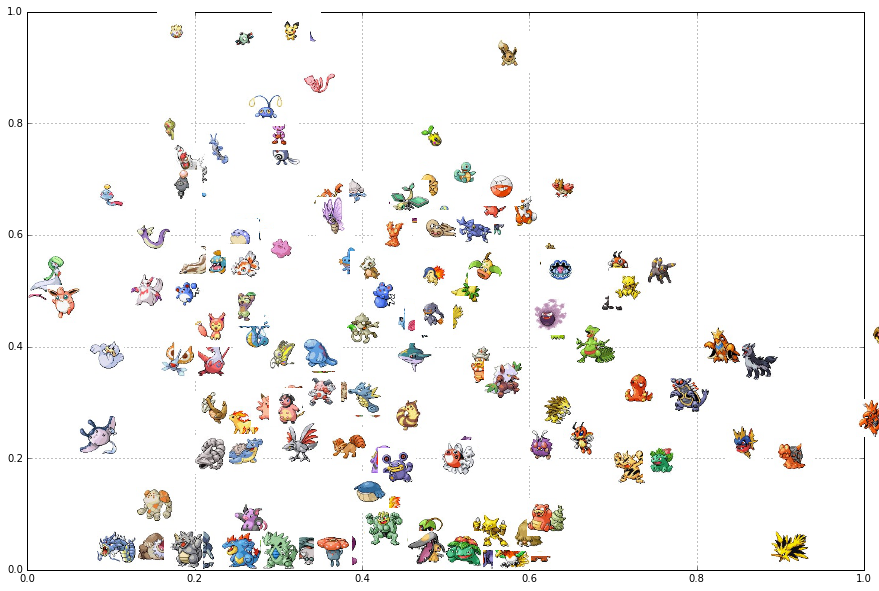

In [365]:
# plot their coordinates:
from matplotlib.offsetbox import AnnotationBbox, OffsetImage

fig = plt.gcf()
fig.clf()
ax = plt.subplot(111)
fig.set_size_inches(15, 10)

# random shuffle pokemon
r = random.sample(range(len(pkmn)), 300)

for i in range(150):
    # show first few pokemon:
    imm = pkmn[r[i]]
    imagebox = OffsetImage(imm, zoom=.6)
    xy = (coords[r[i]]).tolist()  # coordinates 

    ab = AnnotationBbox(imagebox, xy,
        xybox=(20, 20),frameon=False,
        xycoords='data',
        boxcoords="offset points")                                  
    ax.add_artist(ab)

# show image
ax.grid(True)
plt.draw()
plt.show()

## Training the Generative Model

In [ ]:
## Actually build the model object

gan = GAN(nchan=4,c1filts=5,c1filtsize=10,c2filts=5,c2filtsize=5,\
                dc1filts=5,dc1filtsize=5,dc2filts=4,dc2filtsize=10,zdim1=100,zdim2=16,imsize=64)
gan.build()

## More Data

To train a GAN, using a dataset of only 400 pokemon is not really enough, so I am going to compile images of pokemon from other sources. For this I scrape the pokemondb site. They have an image of each pokemon, and I managed to find a csv of all pokemon names, so I can combine these two to easily parse new images of pokemon.

For example, here is the link to an image of mewtwo:

https://img.pokemondb.net/artwork/mewtwo.jpg

I found the pokemon csv file from the "pokedex" github, which was very helpful.

https://github.com/veekun/pokedex/blob/master/pokedex/data/csv/pokemon.csv

A little bit of preprocessing will need to be done on the resulting images from this method.
